In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *

from sklearn import preprocessing

#from keras.layers import Dense, Input, BatchNormalization, Dropout, LSTM
#from keras.models import Sequential
#from keras.optimizers import SGD, Adam
#from keras.models import load_model
#from keras.layers import LeakyReLU

In [4]:
path = os.getcwd()

In [5]:
os.chdir(path)
#os.chdir('/Users/ilmaruduste/School/Masinõpe') #Ilmar
# os.chdir('E:\ML\grid_congestion_manager') #Sille PC

In [6]:
grid_load = pd.read_csv('grid_congestion_data/gridload.csv', index_col= [0])
grid_locations = pd.read_csv('grid_congestion_data/grid_locations.csv', index_col= [0])
ev_home = pd.read_csv('grid_congestion_data/ev_home_locations.csv', index_col= [0])
public_chargers = pd.read_csv('grid_congestion_data/public_chargers_locations.csv', index_col= [0])
ev_history = pd.read_csv('grid_congestion_data/ev_history.csv', index_col= [0])
cars = pd.read_csv('grid_congestion_data/ev_models.csv', index_col= [0])

### CLUSTERING CHARGING STATIONS TO SUBSTATIONS

In [7]:
# find eucleidian distance between points (x1, y1) and (x2, y2)
def x_y_distance(x1, y1, x2, y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2) 

# method adds closest grid cadaster to dataframe
def closest_grid_cadaster(location, grid):
    closest_grids = [] # list used to update dataframe later
    
    # iter over all locations
    for l in location.iterrows():
        # temp variables
        min_distance = None
        closest_grid = None
        
        # find distance from location l to all grids g
        for g in grid.iterrows():
            distance = x_y_distance(l[1].x, l[1].y, g[1].x, g[1].y)
            
            # if closer than previous closest grid, then overwrite
            if min_distance == None or distance < min_distance:
                min_distance = distance
                closest_grid = g[1].cadaster
                
        closest_grids.append(closest_grid)
    
    #update dataframe
    location.loc[:,"closest_grid_cadaster"] = closest_grids
    
closest_grid_cadaster(ev_home, grid_locations)
closest_grid_cadaster(public_chargers, grid_locations)

In [8]:
ev_home.head()

,address,cadaster,latitude,longitude,x,y,closest_grid_cadaster
0,"1, Kvissentali põik, Ülejõe, Tartu linn, Tartu...",79514:037:0033,58.406210,26.706300,6477173.28,658139.66,79514:037:0108
1,"28b/1, Orava, Raadi-Kruusamäe, Tartu linn, Tar...",79512:036:0020,58.389311,26.737114,6475347.92,660042.39,79512:038:0010
2,"16, Alevi, Karlova, Tartu linn, Tartu, Tartu l...",79508:016:0001,58.362547,26.726161,6472365.82,659521.12,79508:020:0022
3,"37, Voolu, Variku, Tartu linn, Tartu, Tartu li...",79509:019:0003,58.346618,26.702650,6470513.21,658227.79,79509:019:0001
4,"12, Ilmatsalu, Veeriku, Tartu linn, Tartu, Tar...",79502:006:0095,58.375785,26.690146,6473716.85,657353.49,79502:020:0001


### SUBSTATION LOADS PROCESSING

In [9]:
#calculating baseloads

cadasters = grid_load['cadaster'].unique()
baseloads = dict()

for cadaster in cadasters: # lets make a empty dict with correct structure
    one_day_loads = np.zeros((24)) #24 hours in a day
    baseloads[cadaster] = one_day_loads

for index, row in grid_load.iterrows(): #insert correct elements into dict
    
    baseloads[row['cadaster']][row['time']-1] = row['baseload']


In [10]:
#make dict with different car model's chargning powers
charging_powers = dict()
for index, row in cars.iterrows():
    
    charging_powers[row['models']] = row['charge_power']

In [11]:
#make dict with loads from ev charging
ev_loads = dict()
for cadaster in cadasters: 
    one_day_loads = np.zeros((24)) #24 hours in a day
    ev_loads[cadaster] = one_day_loads

for index, row in ev_history.iterrows(): #scan over history
    if row['connected'] == True and row['charge_need'] != 0: #check if car is connected and needs charge
        
        cadaster_of_interest = row['cadaster'] #have to find out whats the closest substation for this cadaster
        for index, public_row in public_chargers.iterrows(): #scan public chargers
            if public_row['cadaster'] == cadaster_of_interest:
                ev_loads[public_row['closest_grid_cadaster']][row['time']-1] += charging_powers[row['model']]
             
                break     
        
        for index, home_row in ev_home.iterrows(): #scan home chargers
            if home_row['cadaster'] == cadaster_of_interest:
                ev_loads[home_row['closest_grid_cadaster']][row['time']-1] += charging_powers[row['model']]
               
                break

In [12]:
power_limits = dict()

for index, row in grid_locations.iterrows():
    power_limits[row['cadaster']] = row['max_current']

### LEGEND

In [10]:
#cadasters #all cadasters for substations
#baseloads #dictionary for baseloads for each substation (key: cadaster, value: 24 element array)
#ev_loads #dictionary for ev charging loads for each substation (key: cadaster, value: 24 element array)
#power_limits #dictionary for power limits for each substation (key: cadaster, value: 24 element array)

### VISUALISATION

Making the dictionaries into a Pandas DataFrame so I can visualise it in PlotNine.

In [13]:
loads_dataframe = pd.DataFrame.from_dict([baseloads, power_limits]).T
ev_loads_dataframe = pd.DataFrame.from_dict([ev_loads, power_limits]).T
loads_dataframe.columns = ['baseloads','power_limit']
ev_loads_dataframe.columns = ['ev_loads','power_limit']

loads_dataframe = loads_dataframe.explode('baseloads')
ev_loads_dataframe = ev_loads_dataframe.explode('ev_loads')
loads_dataframe['ev_loads'] = ev_loads_dataframe['ev_loads']

hour_array = []
for i in range(1200):
    hour_array.append(i%24)
loads_dataframe['hour'] = hour_array

loads_dataframe = loads_dataframe.reset_index()
loads_dataframe.columns = ['cadaster', 'baseloads', 'power_limit', 'ev_loads', 'hour']

loads_dataframe.head()
# print(loads_dataframe.shape)

,cadaster,baseloads,power_limit,ev_loads,hour
0,79511:003:0022,98.9976,200,0,0
1,79511:003:0022,104.894,200,0,1
2,79511:003:0022,85.2187,200,0,2
3,79511:003:0022,98.9416,200,0,3
4,79511:003:0022,79.8893,200,0,4


In [14]:
loads_dataframe['baseloads'] = loads_dataframe['baseloads'].astype('float')
loads_dataframe['power_limit'] = loads_dataframe['power_limit'].astype('float')
loads_dataframe['ev_loads'] = loads_dataframe['ev_loads'].astype('float')

loads_dataframe.dtypes

cadaster        object
baseloads      float64
power_limit    float64
ev_loads       float64
hour             int64
dtype: object

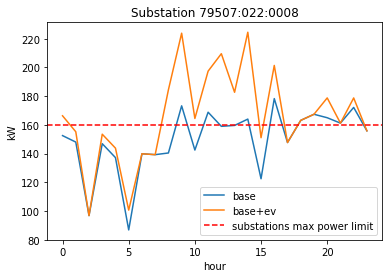

In [16]:
plt.plot(baseloads['79507:022:0008'], label = 'base')
plt.xlabel('hour')
plt.ylabel('kW')
plt.title('Substation 79507:022:0008')
plt.plot(baseloads['79507:022:0008']+ev_loads['79507:022:0008'], label = 'base+ev')
plt.axhline(y=power_limits['79507:022:0008'], color='r', linestyle='--',label = 'substations max power limit')
plt.legend()
plt.show()

In [17]:
# plotnine.options requires another import. This is a minor inconvenience, but it gets the job done
import plotnine

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


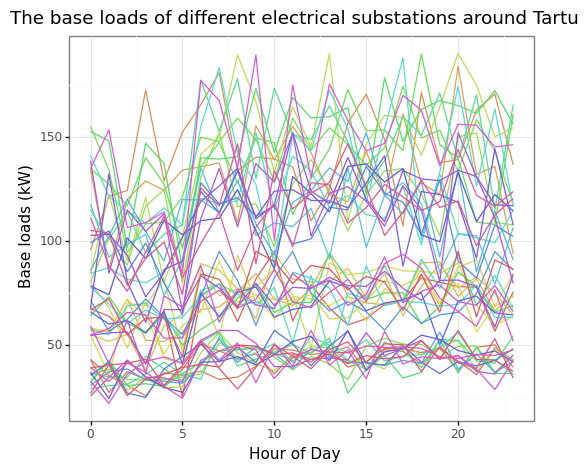

<ggplot: (8747477150453)>

In [18]:

plotnine.options.figure_size = (6,5)

fig = (
    ggplot(data = loads_dataframe, mapping = aes(x = 'hour', color = 'cadaster')) + geom_line(mapping = aes(y='baseloads')) +
    theme_bw() + xlab('Hour of Day') + ylab('Base loads (kW)') + scale_color_discrete(guide=False) + ggtitle('The base loads of different electrical substations around Tartu') +
    theme(text=element_text(family="Helvetica"))
)
fig

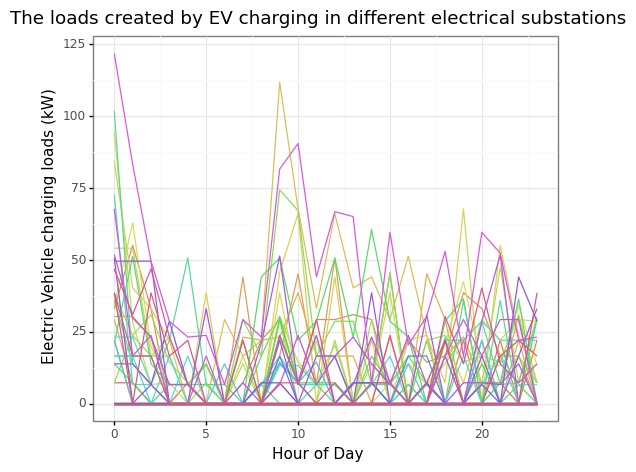

<ggplot: (8747477125289)>

In [19]:

plotnine.options.figure_size = (6,5)

fig = (
    ggplot(data = loads_dataframe, mapping = aes(x = 'hour', color = 'cadaster')) + geom_line(mapping = aes(y='ev_loads')) +
    theme_bw() + xlab('Hour of Day') + ylab('Electric Vehicle charging loads (kW)') + scale_color_discrete(guide=False) + ggtitle('The loads created by EV charging in different electrical substations') +
    theme(text=element_text(family="Helvetica"))
)
fig

Calculating average loads in the whole dataframe. Also constructing a tall dataframe to experiment with ggplot visualisations.

In [20]:
avg_loads_dataframe = loads_dataframe.groupby('hour').mean().reset_index()
avg_loads_dataframe['combined_load'] = avg_loads_dataframe['baseloads'] + avg_loads_dataframe['ev_loads']
avg_loads_dataframe.head()

avg_loads_dataframe_tall = pd.melt(avg_loads_dataframe.drop(columns = ['power_limit'], axis=1), id_vars=['hour'], value_vars=['baseloads', 'ev_loads', 'combined_load'])

loads_order_dict = {'combined_load':2, 'baseloads':1, 'ev_loads':0}
avg_loads_dataframe_tall = avg_loads_dataframe_tall.sort_values(by=['variable'], key = lambda x: x.map(loads_order_dict))

avg_loads_dataframe_tall.head()


,hour,variable,value
35,11,ev_loads,6.554
26,2,ev_loads,9.938
27,3,ev_loads,4.898
28,4,ev_loads,3.456
29,5,ev_loads,3.458


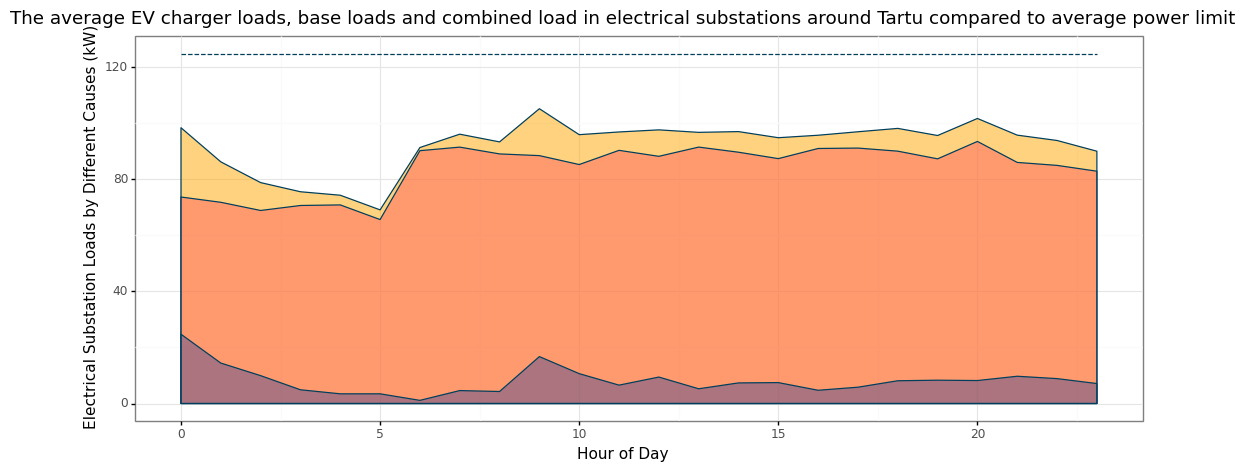

<ggplot: (8747477177361)>

In [21]:

plotnine.options.figure_size = (13,5)

fig = (
    ggplot(data = avg_loads_dataframe, mapping = aes(x = 'hour')) + 
    # geom_line(mapping = aes(y='ev_loads'), color="black") +
    # geom_line(mapping = aes(y='baseloads')) +
    # geom_line(mapping = aes(y='power_limit')) +
    geom_area(mapping = aes(y='combined_load'), color="#003f5c", fill = "#ffa600", alpha = 0.5) +
    geom_area(mapping = aes(y='baseloads'), color="#003f5c", fill="#ff6361", alpha = 0.5) +
    geom_area(mapping = aes(y='ev_loads'), color="#003f5c", fill="#58508d", alpha = 0.5) +
    # geom_area(mapping = aes(y='combined_load'), color="#1f4250", fill = "#f3ff82", alpha = 1) +
    # geom_area(mapping = aes(y='baseloads'), color="#1f4250", fill="#17b79c", alpha = 1) +
    # geom_area(mapping = aes(y='ev_loads'), color="#1f4250", fill="#1f4250", alpha = 1) +
    geom_line(mapping = aes(y='power_limit'), color="#003f5c", linetype = "dashed") +
    theme_bw() + xlab('Hour of Day') + ylab('Electrical Substation Loads by Different Causes (kW)') + scale_color_discrete(guide=False) + ggtitle('The average EV charger loads, base loads and combined load in electrical substations around Tartu compared to average power limit') + labs(color="Legend") + 
    theme(text=element_text(family="Helvetica"))
)
fig

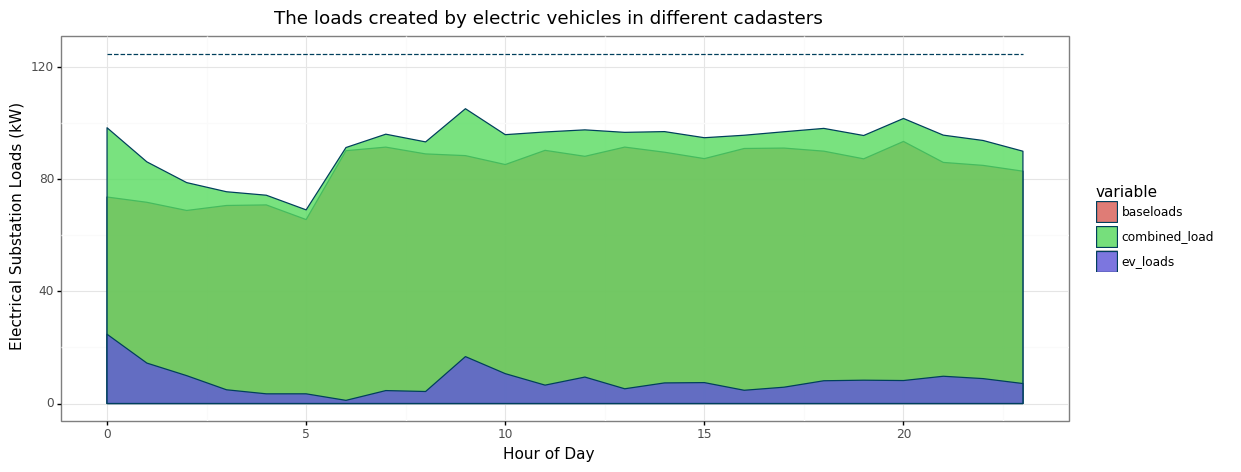

<ggplot: (8747477151021)>

In [22]:
plotnine.options.figure_size = (13,5)

fig = (
    ggplot(data = avg_loads_dataframe_tall, mapping = aes(x = 'hour')) + 
    geom_area(mapping = aes(y='value', fill = 'variable'), color="#003f5c", alpha = 0.8, position = position_dodge(width=0)) +
    geom_line(mapping = aes(y=124.8), color="#003f5c", linetype = "dashed") +
    theme_bw() + xlab('Hour of Day') + ylab('Electrical Substation Loads (kW)') + 
    #scale_fill_manual(breaks = ["combined_load", "baseloads", "ev_loads"],values = ['#ff6361', '#ffa600', '#58508d']) + 
    ggtitle('The loads created by electric vehicles in different cadasters') +
    theme(text=element_text(family="Helvetica"))
    )
fig

## FILTERING SUBSTATIONS THAT ARE CONNECTED TO AT LEAST 1 CHARGING STATION

In [23]:
#remove substations with no conncetions
significant_substations = grid_locations[grid_locations['cadaster'].isin(ev_home['closest_grid_cadaster']) | grid_locations['cadaster'].isin(public_chargers['closest_grid_cadaster'])]
significant_substations.reset_index(inplace = True)

significant_substations = significant_substations.copy()

significant_substations['public_chargers'] = np.zeros((len(significant_substations),1))
significant_substations['home_chargers'] = np.zeros((len(significant_substations),1))


#HOW MANY STATIONS ARE CONNECTED TO THESE SUBSTATIONS
for index,row in public_chargers.iterrows():
    significant_substations.loc[significant_substations.cadaster == row['closest_grid_cadaster'],'public_chargers'] += 1
    
for index,row in ev_home.iterrows():
    significant_substations.loc[significant_substations.cadaster == row['closest_grid_cadaster'],'home_chargers'] += 1

In [24]:
significant_substations['total_chargers'] = np.zeros((len(significant_substations),1))

In [25]:
for index,row in significant_substations.iterrows():
    significant_substations.loc[index,'total_chargers'] = row['home_chargers'] + row['public_chargers']

## TRAIN TEST SPLIT

In [43]:
#train/test split
from sklearn.model_selection import train_test_split

train, test = train_test_split(significant_substations, test_size=0.2, random_state=42, shuffle = True)

## TRAIN/TEST PREP AND TO CSV

In [44]:
train = train.copy()
train.drop(['index'],axis= 'columns', inplace = True) #drop unnessesarcy
train.reset_index(inplace = True) #reset index
ev = pd.DataFrame.from_dict(ev_loads) #transform EV loads to dataframe
train = pd.merge(train, ev.T, right_index=True, left_on='cadaster') #join ev loads with train on cadaster
train.to_csv("train.csv", sep=";")
baseloads.to_csv("baseloads.csv", sep=";")

In [40]:
train.head()

,index,address,cadaster,latitude,longitude,x,y,max_current,public_chargers,home_chargers,...,14,15,16,17,18,19,20,21,22,23
0,24,"Juure, Jaamamõisa, Tartu linn, Tartu, Tartu li...",79301:001:0342,58.383253,26.764144,6474748.69,661646.72,100,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7.2,7.2,0.0,0.0
1,16,"33, Viljandi mnt, Maarjamõisa, Tartu linn, Tar...",79502:019:0018,58.370127,26.689523,6473103.15,657342.63,60,2.0,5.0,...,22.0,0.0,22.0,23.7,7.2,67.7,0.0,55.0,23.7,7.2
2,8,"68a/3, Puiestee, Raadi-Kruusamäe, Tartu linn, ...",79512:032:0012,58.390462,26.727509,6475460.14,659468.49,160,1.0,0.0,...,7.2,0.0,0.0,7.2,0.0,0.0,0.0,0.0,0.0,0.0
3,15,"16a, Roosi, Ülejõe, Tartu linn, Tartu, Tartu l...",79514:014:0021,58.385042,26.730641,6474849.44,659676.18,160,1.0,4.0,...,13.8,6.6,23.7,6.6,0.0,0.0,28.6,51.7,0.0,0.0
4,12,"2, Juhan Liivi, Kesklinn, Tartu linn, Tartu, T...",79507:022:0008,58.378215,26.714904,6474067.16,658809.66,160,3.0,2.0,...,60.5,28.6,23.1,0.0,0.0,0.0,13.8,0.0,6.6,0.0


In [38]:
test = test.copy()
test.drop(['index'],axis= 'columns', inplace = True) #drop unnessesarcy
test.reset_index(inplace = True) #reset index
ev = pd.DataFrame.from_dict(ev_loads) #transform EV loads to dataframe
test = pd.merge(test, ev.T, right_index=True, left_on='cadaster') #join ev loads with test on cadaster
test.to_csv("test.csv", sep=";")

In [39]:
grid_locations2 = grid_locations.copy()
#grid_locations2.drop(['index'],axis= 'columns', inplace = True) #drop unnessesarcy
grid_locations2.reset_index(inplace = True) #reset index
ev = pd.DataFrame.from_dict(ev_loads) #transform EV loads to dataframe
grid_locations2 = pd.merge(grid_locations2, ev.T, right_index=True, left_on='cadaster') #join ev loads with grid_locations2 on cadaster
grid_locations2.to_csv("grid_locations_processed.csv", sep=";")

In [32]:
grid_locations2.head()

,index,address,cadaster,latitude,longitude,x,y,max_current,0,1,...,14,15,16,17,18,19,20,21,22,23
0,134,"2, Aardla, Ropka, Tartu linn, Tartu, Tartu lin...",79511:003:0022,58.355604,26.730697,6471601.92,659795.21,200,0.0,0.0,...,0.0,0.0,16.5,16.5,0.0,0.0,0.0,0.0,0.0,0.0
1,136,"66, Peetri, Raadi-Kruusamäe, Tartu linn, Tartu...",79512:038:0009,58.390402,26.730959,6475470.49,659684.48,160,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,177,"64, Metshaldja, Ihaste, Tartu linn, Tartu, Tar...",79517:014:0024,58.352182,26.777857,6471306.96,662602.18,160,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,88,"11, Risti, Raadi-Kruusamäe, Tartu linn, Tartu,...",79512:029:0011,58.393000,26.724314,6475718.16,659262.11,60,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,94,"8, Kristalli, Ränilinn, Tartu linn, Tartu, Tar...",79505:005:0079,58.349762,26.683184,6470844.17,657076.56,160,0.0,0.0,...,16.5,6.6,16.5,7.2,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
#for creating timestep sequences
#from some tutorial 
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [34]:
#add 2 timesteps to dataframe
df = pd.DataFrame(columns=['x','y','public_chargers','home_chargers','time','t-2','t-1','present'])

for i in range(len(train)):
    seq = list(train.loc[i,range(0,24)])
    steps = 2 
    past_steps, present = split_sequence(seq, steps)
    
    for j in range(steps,24):
        
        row_df = list(train.loc[i,['x','y','public_chargers','home_chargers']].values)
        row_df.append(j) #time
        row_df.append(past_steps[j-steps][0]) # t-2 load
        row_df.append(past_steps[j-steps][1]) # t-1 load
        row_df.append(present[j-steps]) #present load (to predict)
        
        series = pd.Series(row_df, index = df.columns)
        df = df.append(series, ignore_index= True) 

## ILMARI ANDMED

In [35]:
#baseloads

In [47]:
baseloads = pd.DataFrame.from_dict(baseloads)
#train = pd.merge(train, baseloads.T, right_index=True, left_on='cadaster')
#0_x is ev charging current, 0_y is baseload current
#baseloads.T
baseloads.to_csv("baseloads.csv", sep=";")

In [37]:
#power = pd.DataFrame.from_dict(power_limits) #transform EV loads to dataframe
#train = pd.merge(train, ev.T, right_index=True, left_on='cadaster')
#df3

In [165]:
df3 = pd.DataFrame(columns=['cadaster','address','max_current','latitude','longitude','hour','ev_charge'])

for i in range(len(grid_locations2)):
    seq = list(grid_locations2.loc[i,range(0,24)])
    steps = 0
    past_steps, present = split_sequence(seq, steps)
    
    for j in range(0,24):
        
        row_df = list(grid_locations2.loc[i,['cadaster','address','max_current','latitude','longitude']].values)
        row_df.append(j) #time
        #row_df.append(past_steps[j-steps][0]) # t-2 load
        #row_df.append(past_steps[j-steps][1]) # t-1 load
        row_df.append(present[j-steps]) #present load (to predict)
        
        series = pd.Series(row_df, index = df3.columns)
        df3 = df3.append(series, ignore_index= True) 

In [139]:
df3

,cadaster,address,max_current,latitude,longitude,hour,ev_charge
0,79511:003:0022,"2, Aardla, Ropka, Tartu linn, Tartu, Tartu lin...",200,58.355604,26.730697,0,0.0
1,79511:003:0022,"2, Aardla, Ropka, Tartu linn, Tartu, Tartu lin...",200,58.355604,26.730697,1,0.0
2,79511:003:0022,"2, Aardla, Ropka, Tartu linn, Tartu, Tartu lin...",200,58.355604,26.730697,2,0.0
3,79511:003:0022,"2, Aardla, Ropka, Tartu linn, Tartu, Tartu lin...",200,58.355604,26.730697,3,0.0
4,79511:003:0022,"2, Aardla, Ropka, Tartu linn, Tartu, Tartu lin...",200,58.355604,26.730697,4,0.0
...,...,...,...,...,...,...,...
1195,79508:008:0004,"20, Vaba, Karlova, Tartu linn, Tartu, Tartu li...",60,58.365960,26.726441,19,36.4
1196,79508:008:0004,"20, Vaba, Karlova, Tartu linn, Tartu, Tartu li...",60,58.365960,26.726441,20,0.0
1197,79508:008:0004,"20, Vaba, Karlova, Tartu linn, Tartu, Tartu li...",60,58.365960,26.726441,21,7.2
1198,79508:008:0004,"20, Vaba, Karlova, Tartu linn, Tartu, Tartu li...",60,58.365960,26.726441,22,36.4


In [166]:
#df3
df3 = pd.merge(df3, baseloads.T, right_index=True, left_on='cadaster')

In [167]:
for index, row in df3.iterrows():
    df3.loc[index,0] = df3.loc[index,row['hour']]

In [168]:
df3 = df3.rename(columns={0: "baseload"})

In [169]:
df3.drop(range(1,24),axis= 'columns', inplace = True)

In [45]:
df3

NameError: name 'df3' is not defined

In [170]:
df3 = pd.merge(df3,ennustused,how = 'left', left_on = ['cadaster','hour'], right_on = ['cadaster','time'])

In [171]:
df3.loc[df3['ev_prediction'].isna(), 'time'] = True
df3.loc[~df3['ev_prediction'].isna() , 'time'] = False
#f.loc[(df['A'] == 'blue') & (df['B'] == 'red') & (df['C'] == 'square'),'D'] = 'M5'
df3 = df3.rename(columns={'time': "is_train"})

In [172]:
df3['combined_load'] = df3['ev_charge'] + df3['baseload']

In [173]:
df3['predicted_combined_load'] = df3['ev_prediction'] + df3['baseload']

In [174]:
df3 = df3.rename(columns={'ev_prediction': "predicted_ev_load"})

In [149]:
df3.head()

,cadaster,address,max_current,latitude,longitude,hour,ev_charge,baseload,is_train,predicted_ev_load,combined_load,predicted_combined_load
0,79511:003:0022,"2, Aardla, Ropka, Tartu linn, Tartu, Tartu lin...",200,58.355604,26.730697,0,0.0,98.997612,True,NaN,98.997612,NaN
1,79511:003:0022,"2, Aardla, Ropka, Tartu linn, Tartu, Tartu lin...",200,58.355604,26.730697,1,0.0,104.894207,True,NaN,104.894207,NaN
2,79511:003:0022,"2, Aardla, Ropka, Tartu linn, Tartu, Tartu lin...",200,58.355604,26.730697,2,0.0,85.218661,True,NaN,85.218661,NaN
3,79511:003:0022,"2, Aardla, Ropka, Tartu linn, Tartu, Tartu lin...",200,58.355604,26.730697,3,0.0,98.941638,True,NaN,98.941638,NaN
4,79511:003:0022,"2, Aardla, Ropka, Tartu linn, Tartu, Tartu lin...",200,58.355604,26.730697,4,0.0,79.889267,True,NaN,79.889267,NaN


In [ ]:
df3.to_csv("master2.csv", sep=";")

In [175]:
enn = df3.loc[df3['is_train'] == False].copy()

In [176]:
pred = enn.groupby('cadaster')['predicted_ev_load'].apply(list)
real = enn.groupby('cadaster')['ev_charge'].apply(list)

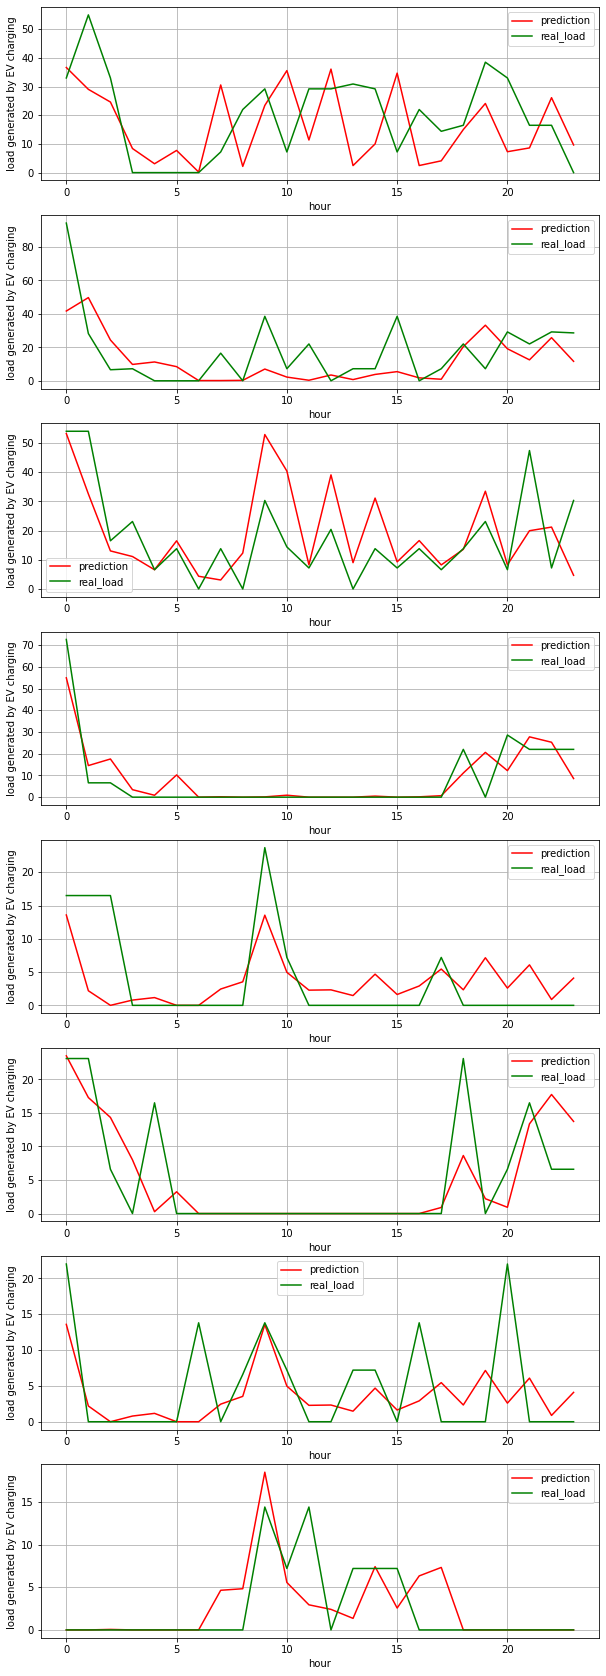

In [185]:
nrows = 8
fig, axes = plt.subplots(nrows, 1,figsize=(10,30),sharey='row')

for i,((key, value),row) in enumerate(zip(pred.items(),axes)):
    row.plot(pred[key], color='red',label = 'prediction')
    
    row.plot(real[key], color='green',label = 'real_load')
    #if i == 0:
    row.legend()
    row.set_xlabel('hour')
    row.set_ylabel('load generated by EV charging')
    row.grid(True)
    #plt.figure()
    #plt.plot(pred[key], label = 'prediction')
    #plt.plot(real[key],label = 'real_ev_charge')
    #plt.legend()
plt.show()

In [ ]:
nrows = 3
fig, axes = plt.subplots(nrows, 2)

In [ ]:
axes[0][0]

## TIME AS ONEHOT

In [42]:

df2 = pd.DataFrame(columns=['public_chargers','home_chargers','time','present'])

for i in range(len(train)):
    seq = list(train.loc[i,range(0,24)])
    steps = 0
    past_steps, present = split_sequence(seq, steps)
    #print(past_steps)
    for j in range(steps,24):
        
        row_df = list(train.loc[i,['public_chargers','home_chargers']].values)
        row_df.append(j) #time
        #row_df.append(past_steps[j-steps][0]) # t-3 load
        #row_df.append(past_steps[j-steps][0]) # t-2 load
        #row_df.append(past_steps[j-steps][1]) # t-1 load
        row_df.append(present[j-steps]) #present load (to predict)
        
        series = pd.Series(row_df, index = df2.columns)
        df2 = df2.append(series, ignore_index= True) 

time_one_hot = pd.get_dummies(df2['time'])
df2 = df2.join(time_one_hot)


In [156]:
df2_test = pd.DataFrame(columns=['cadaster','public_chargers','home_chargers','time','present'])

for i in range(len(test)):
    seq = list(test.loc[i,range(0,24)])
    steps = 0
    past_steps, present = split_sequence(seq, steps)
    
    for j in range(steps,24):
        
        row_df = list(test.loc[i,['cadaster','public_chargers','home_chargers']].values)
        row_df.append(j) #time
        #row_df.append(past_steps[j-steps][0]) # t-3 load
        #row_df.append(past_steps[j-steps][0]) # t-2 load
        #row_df.append(past_steps[j-steps][1]) # t-1 load
        row_df.append(present[j-steps]) #present load (to predict)
        
        series = pd.Series(row_df, index = df2_test.columns)
        df2_test = df2_test.append(series, ignore_index= True) 

time_one_hot = pd.get_dummies(df2_test['time'])
df2_test = df2_test.join(time_one_hot)


In [125]:
df2_test['delta'] = df2_test['present'] - df2_test['present'].shift(1)
df2['delta'] = df2['present'] - df2['present'].shift(1)

df2_test.loc[df2_test['time'] == steps,'delta'] = 0 
df2.loc[df2['time'] == steps,'delta'] = 0 

df2_test['last_delta'] = df2_test['delta'].shift(1)
df2['last_delta'] = df2['delta'].shift(1)


df2_test.loc[df2_test['time'] == steps,'last_delta'] = 0 
df2.loc[df2['time'] == steps,'last_delta'] = 0 
#df['dA'] = df['A'] - df['A'].shift(-1)

In [126]:
df2

,public_chargers,home_chargers,time,t-2,t-1,present,2.0,3.0,4.0,5.0,...,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,delta,last_delta
0,0.0,1.0,2.0,7.2,7.2,0.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
1,0.0,1.0,3.0,7.2,0.0,0.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
2,0.0,1.0,4.0,0.0,0.0,7.2,0,0,1,0,...,0,0,0,0,0,0,0,0,7.2,0.0
3,0.0,1.0,5.0,0.0,7.2,0.0,0,0,0,1,...,0,0,0,0,0,0,0,0,-7.2,7.2
4,0.0,1.0,6.0,7.2,0.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,-7.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633,2.0,6.0,19.0,0.0,22.0,22.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0.0,22.0
634,2.0,6.0,20.0,22.0,22.0,28.6,0,0,0,0,...,0,0,0,0,1,0,0,0,6.6,0.0
635,2.0,6.0,21.0,22.0,28.6,6.6,0,0,0,0,...,0,0,0,0,0,1,0,0,-22.0,6.6
636,2.0,6.0,22.0,28.6,6.6,7.2,0,0,0,0,...,0,0,0,0,0,0,1,0,0.6,-22.0


In [157]:
tunnused  =list(range(steps,24))
tunnused.append('public_chargers')
tunnused.append('home_chargers')
#tunnused.append('last_delta')
#tunnused.append('t-2')
#tunnused.append('t-1')


import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

#min_max_scaler = MinMaxScaler()
#df2[["x", "y"]] = min_max_scaler.fit_transform(df2[["x", "y"]])
#df2_test[["x", "y"]] = min_max_scaler.transform(df2_test[["x", "y"]])

In [158]:
lr = LinearRegression()
lr.fit(df2[tunnused], df2['present'])
pred = lr.predict(df2_test[tunnused])

#pred[pred < 0] = 0

r2 = lr.score(df2_test[tunnused], df2_test['present']) 
rmse = mean_squared_error(df2_test['present'], pred, squared=False)


In [159]:
rmse,r2

(11.142475378342217, 0.40505978362757444)

In [ ]:
for el in zip(pred, np.array(df2_test['present'])):
    print(round(el[0],2),'|', el[1])

In [160]:
rf = RandomForestRegressor(n_estimators=50)
rf.fit(df2[tunnused], df2['present'])
pred = rf.predict(df2_test[tunnused])

#pred[pred < 0] = 0

r2 = rf.score(df2_test[tunnused], df2_test['present']) 
rmse = mean_squared_error(df2_test['present'], pred, squared=False)


In [161]:
rmse,r2

(11.092396865515667, 0.4103955403786317)

In [162]:
delta_pred = pd.DataFrame(pred,columns=['ev_prediction'])

In [134]:
delta_pred['ev_prediction']= delta_pred['ev_prediction'] + df2_test['t-1']

In [163]:
df2_test = df2_test.join(delta_pred)

In [136]:
df2_test

,cadaster,public_chargers,home_chargers,time,t-2,t-1,present,2,3,4,...,17,18,19,20,21,22,23,delta,last_delta,ev_prediction
0,79509:025:0008,1.0,1.0,2,16.5,16.5,16.5,1,0,0,...,0,0,0,0,0,0,0,0.0,0.0,11.550
1,79509:025:0008,1.0,1.0,3,16.5,16.5,0.0,0,1,0,...,0,0,0,0,0,0,0,-16.5,0.0,2.496
2,79509:025:0008,1.0,1.0,4,16.5,0.0,0.0,0,0,1,...,0,0,0,0,0,0,0,0.0,-16.5,2.168
3,79509:025:0008,1.0,1.0,5,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.792
4,79509:025:0008,1.0,1.0,6,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,79510:035:0012,1.0,0.0,19,0.0,0.0,0.0,0,0,0,...,0,0,1,0,0,0,0,0.0,0.0,1.760
172,79510:035:0012,1.0,0.0,20,0.0,0.0,0.0,0,0,0,...,0,0,0,1,0,0,0,0.0,0.0,0.572
173,79510:035:0012,1.0,0.0,21,0.0,0.0,0.0,0,0,0,...,0,0,0,0,1,0,0,0.0,0.0,0.000
174,79510:035:0012,1.0,0.0,22,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,1,0,0.0,0.0,0.000


In [164]:
ennustused =  df2_test[['cadaster','time','ev_prediction']].copy()

In [58]:
ennustused

,cadaster,time,ev_prediction
0,79509:025:0008,1,7.7370
1,79509:025:0008,2,10.9320
2,79509:025:0008,3,3.5755
3,79509:025:0008,4,1.4808
4,79509:025:0008,5,0.4400
...,...,...,...
179,79510:035:0012,19,0.0000
180,79510:035:0012,20,0.0000
181,79510:035:0012,21,0.0000
182,79510:035:0012,22,0.0000


In [ ]:
for el in zip(pred, np.array(df2_test['present'])):
    print(round(el[0],2),'|', el[1])

In [ ]:
list(range(0,24))

## RANDOM FOREST

In [ ]:
#train/val split
train_data, val_data = train_test_split(df, test_size=0.2, random_state=40, shuffle = False)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score


mudel = RandomForestRegressor(n_estimators=100)
mudel.fit(train_data[['x','y','public_chargers','home_chargers','time','t-2','t-1']],np.array(train_data[['present']]).reshape(-1))

In [ ]:
pred = mudel.predict(val_data[['x','y','public_chargers','home_chargers','time','t-2','t-1']])

In [ ]:
#val_data.reset_index(inplace = True)
i = 2
plt.plot(val_data.loc[15+i*22:15+(i+1)*22,['present']], label = 'True')
plt.plot(pred[15+i*22:15+(i+1)*22], label = 'Pred')
plt.legend()
plt.plot()

In [ ]:
values = cross_val_score(mudel, df[['x','y','public_chargers','home_chargers','time','t-2','t-1']], df[['present']].values.ravel(), cv=5, scoring='neg_root_mean_squared_error')

In [ ]:
np.mean(values)

## NEURAL NETWORK

In [186]:
df.describe()

,x,y,public_chargers,home_chargers,time,t-2,t-1,present
count,6.380000e+02,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000
mean,6.473192e+06,659358.077931,1.413793,2.655172,12.500000,11.329467,10.455486,10.033856
std,1.847228e+03,1695.616458,1.403493,2.398370,6.349267,18.028364,16.441587,15.929492
min,6.470565e+06,657076.560000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
25%,6.471602e+06,658197.650000,1.000000,1.000000,7.000000,0.000000,0.000000,0.000000
50%,6.473103e+06,659106.950000,1.000000,2.000000,12.500000,0.000000,0.000000,0.000000
75%,6.474637e+06,659795.210000,2.000000,4.000000,18.000000,16.500000,16.500000,16.500000
max,6.476815e+06,663240.010000,7.000000,10.000000,23.000000,121.700000,111.700000,111.700000


In [187]:
ar = train_data.to_numpy()
X_train = ar[:,:7]
y_train = ar[:,7]

Xminmax = preprocessing.MinMaxScaler()
X_train = Xminmax.fit_transform(X_train)

yminmax = preprocessing.MinMaxScaler()
y_train = yminmax.fit_transform(y_train.reshape(-1,1))


ar = val_data.to_numpy()
X_test = ar[:,:7]
y_test= ar[:,7]

y_test = yminmax.transform(y_test.reshape(-1,1))
X_test = Xminmax.transform(X_test)

NameError: name 'train_data' is not defined

In [ ]:
mdl = Sequential()
mdl.add(Dense(50, activation="relu", input_shape= (7,)))
mdl.add(Dense(32, activation="relu"))
mdl.add(Dense(1, activation="linear"))
mdl.compile(loss="mean_squared_error", optimizer=Adam(0.01))


In [ ]:
hist = mdl.fit(X_train,y_train,validation_split=0.2, epochs = 10, batch_size = 22, verbose = True)
    

In [ ]:
plt.plot(hist.history["loss"], label = 'train loss')
plt.plot(hist.history["val_loss"], label = 'val loss')
plt.legend()
plt.show()

In [ ]:
pred = mdl.predict(X_test)
pred_reaal = yminmax.inverse_transform(pred)
test_reaal = yminmax.inverse_transform(y_test)

In [ ]:
np.sqrt(np.mean((pred_reaal - test_reaal)**2))

## AEGREAD

In [ ]:
under3 = train.loc[train['total_chargers'] == 3].copy()
under3.reset_index(inplace = True)

under2 = train.loc[train['total_chargers'] <= 2].copy()
under2.reset_index(inplace = True)

under5 = train.loc[(train['total_chargers'] <= 5) & (train['total_chargers'] > 3)].copy()
under5.reset_index(inplace = True)

over5 = train.loc[train['total_chargers'] > 5].copy()
over5.reset_index(inplace = True)

In [ ]:
under3.head()

In [ ]:
splits = [under2, under3, under5, over5]
all_series = dict()

for i,split in enumerate(splits):
    series = []
    for j in range(len(split)):
        seq = list(split.loc[j,range(0,24)])
        series.append(seq)
        
    series = np.array(series).reshape(-1)
    all_series[i] = series
    
fig, ax = plt.subplots(2,2,figsize=(20, 6))

ax[0][0].plot(all_series[0])
ax[0][0].set_title('2 charging stations or less')
ax[0][1].plot(all_series[1])
ax[0][1].set_title('3 charging stations')
ax[1][0].plot(all_series[2])
ax[1][0].set_title('4-5 charging stations')
ax[1][1].plot(all_series[3])
ax[1][1].set_title('6+ charging stations')
plt.show()

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(all_series[2])
plt.show()

In [ ]:

from statsmodels.tsa.stattools import adfuller


result = adfuller(all_series[0])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf


plot_acf(all_series[2],lags=50) #MA
plt.show()
plot_pacf(all_series[2],lags = 50) #AR
plt.show()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(all_series[1], order=(2,0,2))
model_fit = model.fit()
print(model_fit.summary())

In [ ]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [ ]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [ ]:
# evaluate an ARIMA model using a walk-forward validation


from sklearn.metrics import mean_squared_error
from math import sqrt

# split into train and test sets

X = all_series[3]

size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(3,0,5))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test, label = 'real')
plt.plot(predictions, color='red',label = 'prediction')
plt.legend()
plt.title('Over 5 charging stations (combined timeseries) ARMA model test data')
plt.show()

In [ ]:
X = all_series[0]

size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(2,0,2))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test, label = 'real')
plt.plot(predictions, color='red',label = 'prediction')
plt.legend()
plt.title('2 or less charging stations (combined timeseries) ARMA model test data')
plt.show()

In [ ]:
X = all_series[1]

size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(2,0,3))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test, label = 'real')
plt.plot(predictions, color='red',label = 'prediction')
plt.legend()
plt.title('3 charging stations (combined timeseries) ARMA model test data')
plt.show()

In [ ]:
X = all_series[2]

size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(2,0,2))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test, label = 'real')
plt.plot(predictions, color='red',label = 'prediction')
plt.legend()
plt.title('4-5 charging stations (combined timeseries) ARMA model test data')
plt.show()